In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import time
import pickle
import datetime
import ast

import torch

import sys
sfp = '/home/ngr4/project/'
sys.path.append(sfp)
from wearables.scripts import models_v3 as wearmodels
from wearables.scripts import data_v3 as weardata
from wearables.scripts import eval_v3 as weareval
from wearables.scripts import utils as wearutils

plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
plt.rcParams['savefig.dpi']=600
sns.set_style("ticks")

In [2]:
pfp = '/home/ngr4/project/wearables/results/'
results_file = os.path.join(pfp, 'GA_robustness_tests.csv')

In [3]:
res = pd.read_csv(results_file, index_col=0)

In [4]:
res

,exp,trial,target,tasktype,eval_test,loss_test,bst_epoch,loss_train,eval_train,loss_val,eval_val
0,ITv3_GA_GA,7,GA,regression,0.247227,84.931541,24,"[439.59401633522725, 366.8679132172556, 291.36...","[-0.002300056492520161, 0.0643678125951296, 0....","[386.1020927429199, 323.522159576416, 273.5295...","[0.04302282398889997, -0.20368177355363165, 0...."
0,ITv3_GA_GA,8,GA,regression,0.435210,84.802231,28,"[435.73349831321025, 363.10304098418266, 295.7...","[0.021719880076804008, 0.03205351386240691, 0....","[364.5415496826172, 302.69446733262805, 226.50...","[0.19999999999999998, 0.9486832980505139, 0.39..."
0,ITv3_GA_GA,4,GA,regression,0.413963,79.975136,38,"[439.30333917791194, 365.7091878255208, 287.13...","[-0.004136524212568875, 0.02253531119198279, 0...","[419.9259270562066, 355.3161349826389, 257.992...","[0.19649243763030108, 0.5749782647867911, 0.29..."
0,ITv3_GA_GA,3,GA,regression,0.392555,90.909325,33,"[428.75237759676844, 346.6153828014027, 260.12...","[-0.04124094675220877, -0.03086518163014154, -...","[363.6077194213867, 282.10342597961426, 205.11...","[-0.10797554140207162, -0.09717163327453823, 0..."
0,ITv3_GA_GA,6,GA,regression,0.283161,89.068184,35,"[425.96791955196494, 339.7492950901841, 254.67...","[0.013830622225578773, -0.051251703807633095, ...","[368.30925369262695, 289.559778213501, 195.199...","[-0.07693552456643318, -0.0027518766936384933,..."
0,ITv3_GA_GA,2,GA,regression,0.346268,86.887566,41,"[440.1680334842566, 366.07070552941525, 287.61...","[0.021614700059330156, 0.046390581875739294, 0...","[400.3637351989746, 330.6189842224121, 254.628...","[0.05623202349221893, 0.12747108888002687, 0.0..."
0,ITv3_GA_GA,1,GA,regression,0.286152,84.931152,23,"[423.07831134218156, 340.5361089995413, 259.59...","[-0.02528175512361824, 0.03581367498209299, 0....","[406.36130777994794, 299.8705817328559, 213.84...","[0.0017551559390397225, 0.1180628196102429, 0...."
0,ITv3_GA_GA,5,GA,regression,0.399888,82.696922,47,"[433.2276481859612, 357.8206084280303, 277.281...","[0.011145993525053697, 0.0333851142665285, 0.0...","[428.56649441189234, 348.724353366428, 260.345...","[-0.3870052768476253, -0.4511913307531282, -0...."


In [5]:
trainer, res = wearutils.load_IT('/home/ngr4/scratch60/38-ITv3_GA_GA4.pkl')

/gpfs/ysm/project/dijk/ngr4/conda_envs/wearables/lib/python3.8/site-packages/torch/nn/modules/conv.py:294: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/Convolution.cpp:660.)
  return F.conv1d(input, weight, bias, self.stride,
/gpfs/ysm/project/dijk/ngr4/conda_envs/wearables/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


test set eval:
  bst epoch: None
  <loss_test>=79.3171
  eval_test  =0.3882


In [10]:
# check MAE
def eval_performance(output, target, mode='mae', n_trials=10, nan20=False, convert2numpy=False):
    if convert2numpy:
        # evals in numpy, so convert to host mem
        output = output.cpu().detach().numpy()
        target = target.cpu().detach().numpy()
    if mode=='spearmanr':
        # Spearman's Rho
        rho, p = spearmanr(output, target)
        return rho.item()
    elif mode=='auprc_adjusted':
        # AU-PRC vs. random (AU-PRC adjusted)
        auprc_model = weareval.auprc(output, target, nan20=nan20)
        random_clf = torch.distributions.normal.Normal(0, 1)
        auprc_random = 0.
        for n in range(n_trials):
            random_output = random_clf.sample((output.shape[0], output.shape[1]))
            if output.size > 1:
                random_output = torch.softmax(random_output, dim=-1)
            else:
                random_output = torch.sigmoid(random_output)
            auprc_random += weareval.auprc(random_output, target, nan20=nan20)
        auprc_random = auprc_random / n_trials
        return (auprc_model - auprc_random) / (1 - auprc_random)
    elif mode=='mae':
        return np.mean(np.abs(output - target))

In [20]:
robustness_mae = []
for modelpkl in glob.glob('/home/ngr4/scratch60/*ITv3_GA*.pkl'):
    trainer, res = wearutils.load_IT(modelpkl)
    robustness_mae.append(eval_performance(res['yhat'], res['y'], convert2numpy=True))
    
print('Ave: {:.1f}\t SD: {:.2f}'.format(np.mean(robustness_mae), np.std(robustness_mae)))

test set eval:
  bst epoch: None
  <loss_test>=67.1415
  eval_test  =0.5260
test set eval:
  bst epoch: None
  <loss_test>=83.7214
  eval_test  =0.2974
test set eval:
  bst epoch: None
  <loss_test>=92.3170
  eval_test  =0.2179
test set eval:
  bst epoch: None
  <loss_test>=76.0226
  eval_test  =0.4088
test set eval:
  bst epoch: None
  <loss_test>=72.4249
  eval_test  =0.4633
test set eval:
  bst epoch: None
  <loss_test>=88.9512
  eval_test  =0.2432
test set eval:
  bst epoch: None
  <loss_test>=78.7448
  eval_test  =0.4108
test set eval:
  bst epoch: None
  <loss_test>=82.3269
  eval_test  =0.3739
test set eval:
  bst epoch: None
  <loss_test>=79.3171
  eval_test  =0.3882
Ave: 7.6	 SD: 0.40


In [11]:
# select top-1 based on loss_test
loss_train = ast.literal_eval(res.loc[res['trial']==4, 'loss_train'].values[0])
loss_val = ast.literal_eval(res.loc[res['trial']==4, 'loss_val'].values[0])


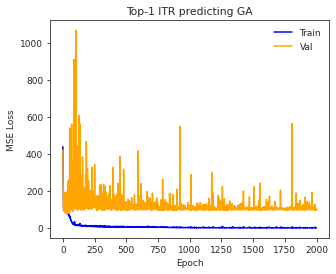

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

ax.plot(np.arange(len(loss_train)), loss_train, color='blue', label='Train')
ax.plot(np.arange(len(loss_val)), loss_val, color='orange', label='Val')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.legend()
ax.set_title('Top-1 ITR predicting GA')

fig.savefig(os.path.join(pfp, 'ITv3_GA_top1_loss.png'), bbox_inches='tight', dpi=300)